# Poisson Noise Treatment

In [1]:
import cv2 as cv
from matplotlib import pyplot as plt
import numpy as np
import skimage
# from skimage.util import random_noise

The method "cv.imread()" returned:
An image of <class 'numpy.ndarray'>.
The shape of the "img" is (2494, 2048, 3)
Where each element has type: <class 'numpy.uint8'>
The x dimension is 2048, the y dim is 2494 andthe number of channels is 3


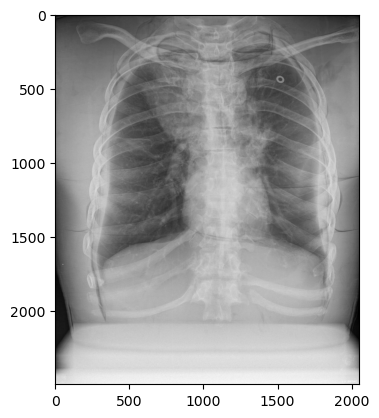

In [2]:
img_location: str = '../images/img_2048x2494x15.jpg'
img = cv.imread(img_location)
plt.imshow(img)
print(f"The method \"cv.imread()\" returned:\nAn image of {type(img)}.\n\
The shape of the \"img\" is {img.shape}\n\
Where each element has type: {type(img[0, 0, 0])}")
nrow, ncol, nch = img.shape
print(f"The x dimension is {ncol}, the y dim is {nrow} and\
the number of channels is {nch}")
plt.show()

- **NOTE**: The image has some extra pixels in the y-axis. Before proceeding we crop it.

The cropped image has dimensions: (2048, 2048, 3)


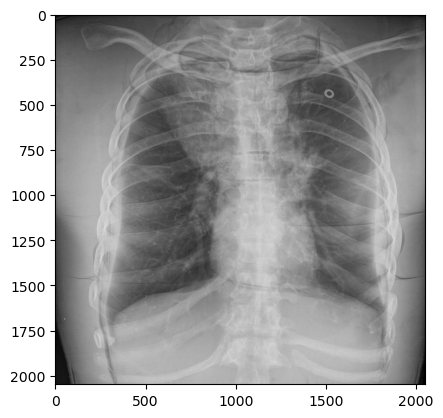

In [3]:
cropped_img = img[0:2048, :, :]
cv.imwrite('../images/cropped_img.jpg', cropped_img)
plt.imshow(cropped_img)
print(f"The cropped image has dimensions: {cropped_img.shape}")
plt.show()

## Adding Poisson Noise

### Poisson Distribution Review
- The Poisson distribution has the following form:
$$f(k;\lambda) = \frac{\lambda^ke^{-\lambda}}{k!},$$
- where, $k$ is the light intensity (number of photons per unit of time measured) and $\lambda$ is the expected value which is also its variance.
- Direct numerical applications of the Poisson distribution will suffer from overflow due to its exponential nature. A mapping from the $k$ values of $\left(0, \infty\right)$ to the interval $\left(0, 1\right)$ it is required. 
- Poisson Noise is the noise that follows the distribution $f(k;\lambda)$. It is also known as Shot noise, self noise or photon noise.

In [26]:
def apply_poisson_noise(image):
    # we convert image from unit8 to float to use Poisson rand gen
    image = np.asarray(image, np.dtype('float64').type)

    # we seed our random variable generator
    rng = np.random.default_rng()

    # to applied the clip values as from 0 to 1 we normalize it
    out = rng.poisson(image) / 255
    # The application of noise can exceed the max range of the mean passed:
    if out.max() > 1.0:
        out = np.clip(out, 0, 1.0)
    return out

# the random.poisson generator accepts only floats as input (see doc.)
# help(np.random.default_rng().poisson)

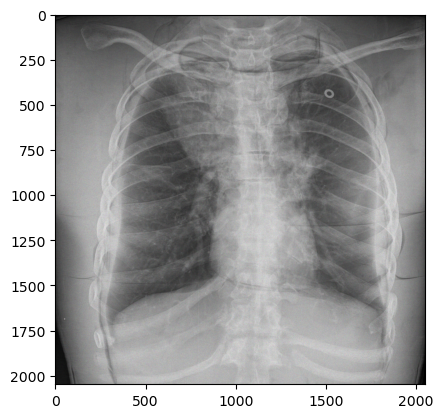

In [27]:
noisy_img = apply_poisson_noise(cropped_img)
# imshow uses as input 0-1 float or 0-255 int
plt.imshow(noisy_img)
# we scale back before saving to float from <0, 1> to unit <0, 255>
conv = noisy_img * 255
# need to convert before saving
skimage.io.imsave('../images/img_with_poisson_noise.jpg', conv.astype(np.uint8))
plt.show()

- To be able to take a look at the noise generated we make a zoom

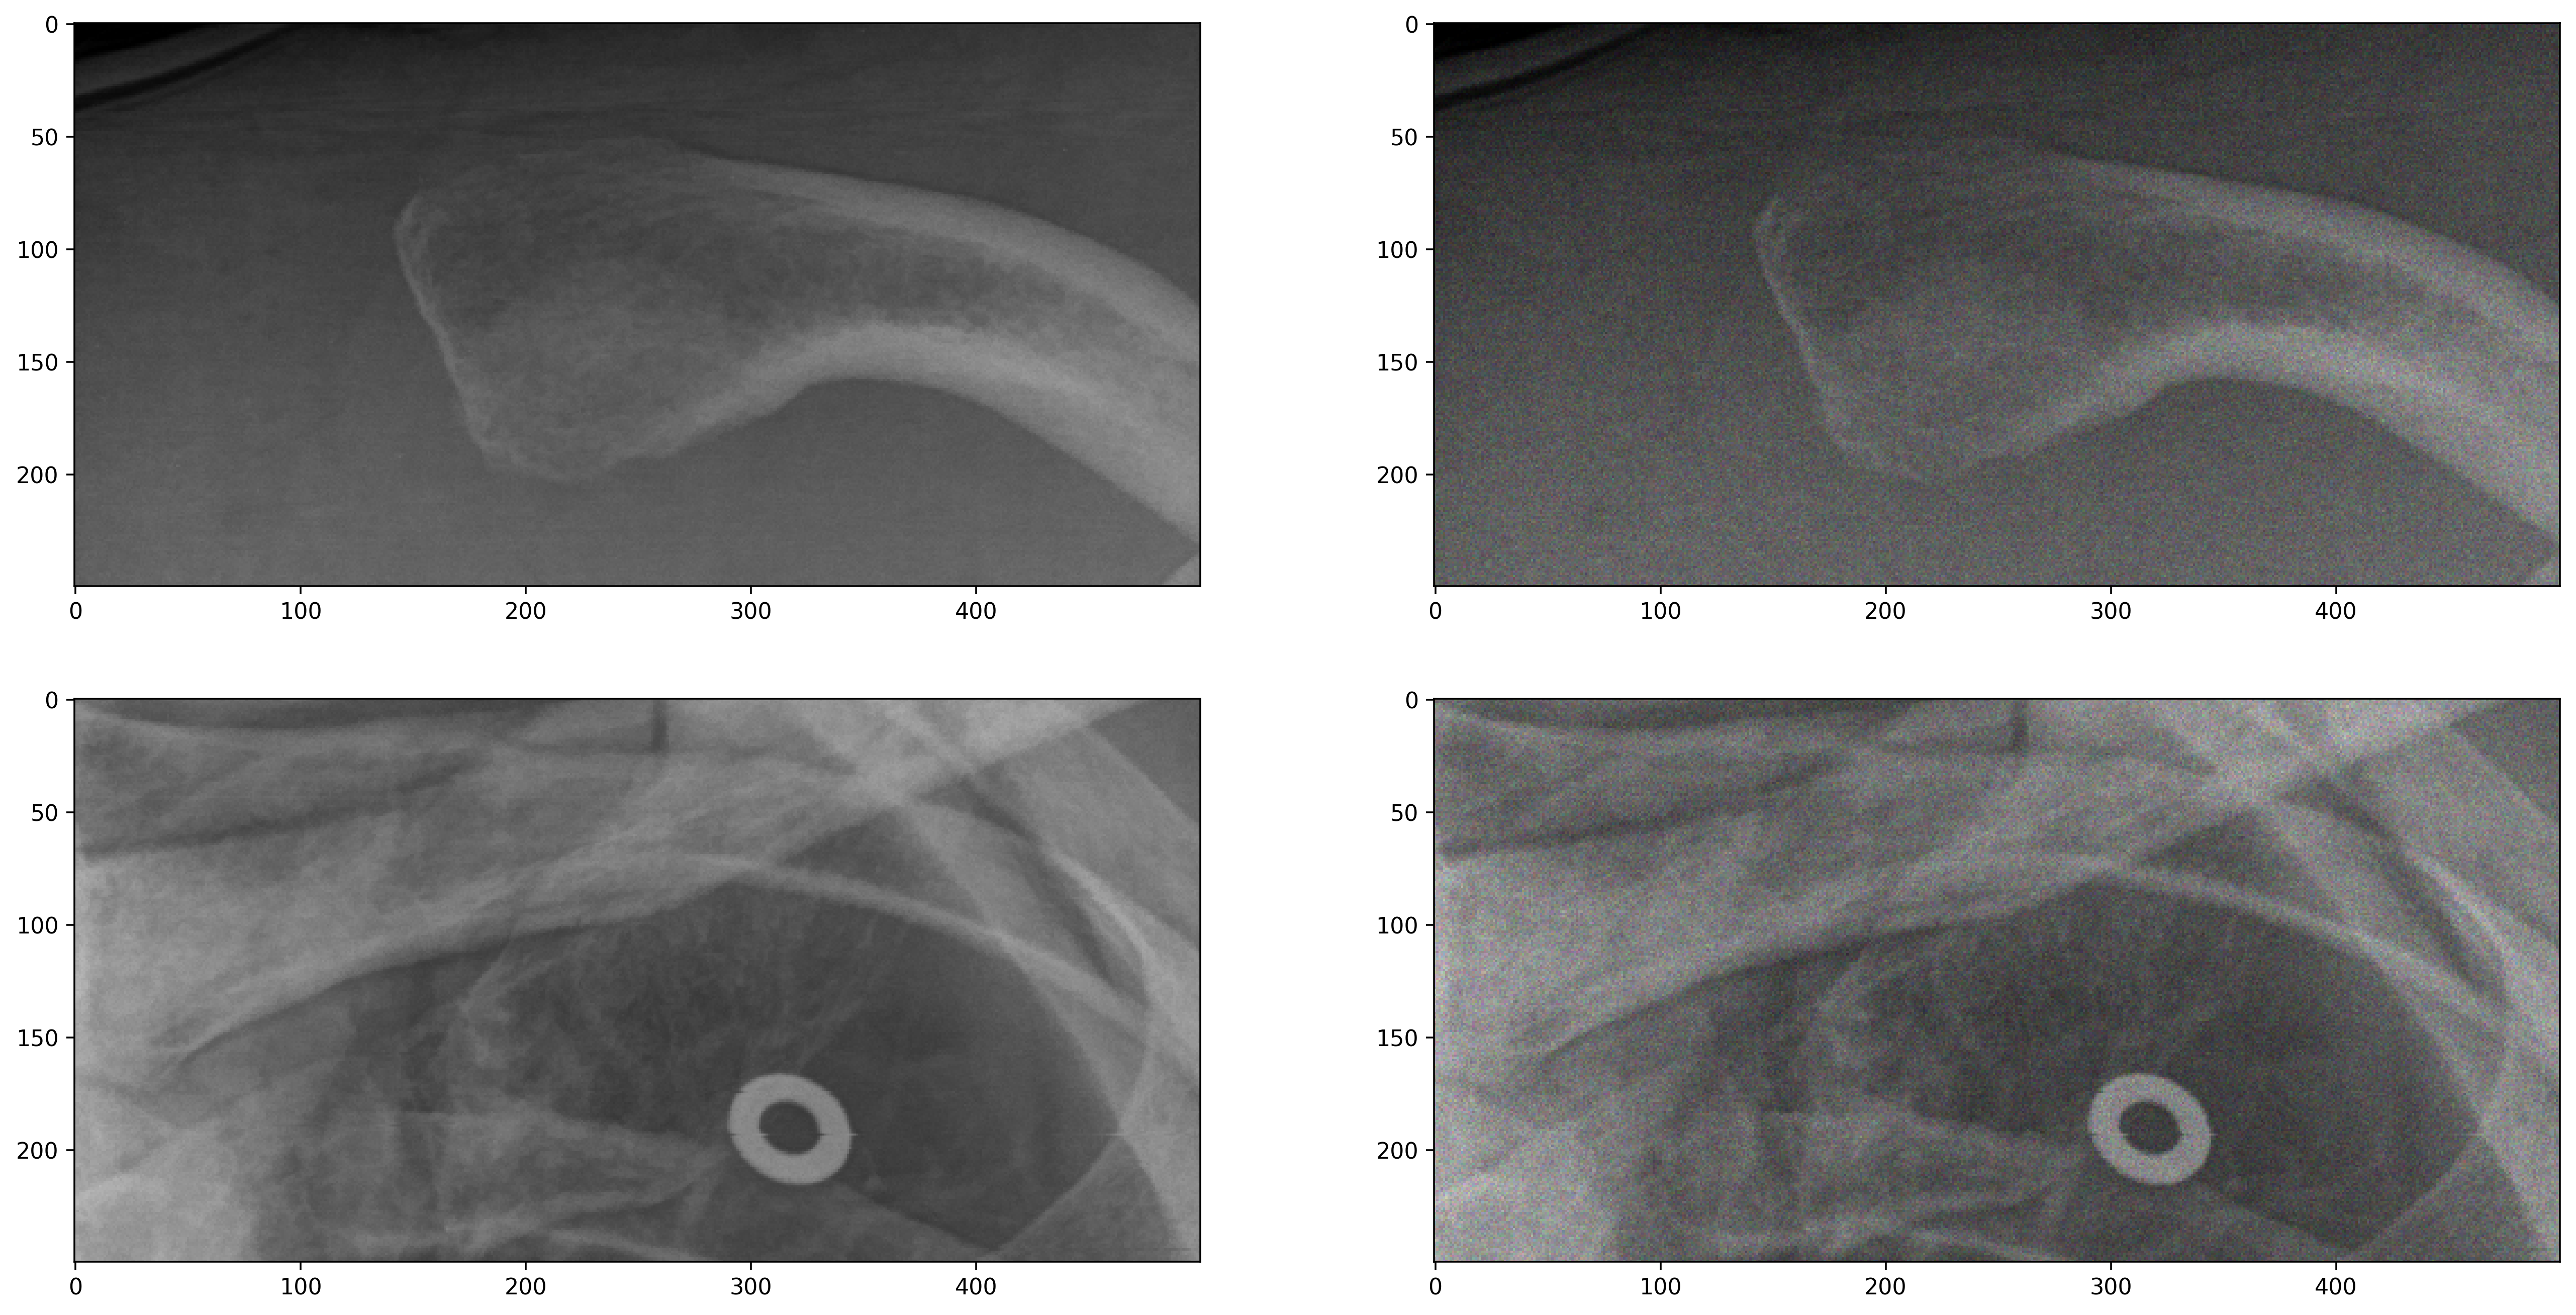

In [28]:
fig11 = cropped_img[0:250, 0:500, :]
fig12 = noisy_img[0:250, 0:500, :]
fig21 = cropped_img[250:500, 1200:1700, :]
fig22 = noisy_img[250:500, 1200:1700, :]
fig = plt.figure(figsize=(20, 10), dpi=320)
ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(222)
ax3 = fig.add_subplot(223)
ax4 = fig.add_subplot(224)
ax1.imshow(fig11)
ax2.imshow(fig12)
ax3.imshow(fig21)
ax4.imshow(fig22)
plt.show()

## Noise Removal

### Considerations:
1. Poisson noise is signal dependent/scene dependent, has its origins in the intrinsic nature of light. At the quantum level photons have an uncertain behaviour which introduces a stochastic behaviour that when measured it follows the Poisson distribution.
2. To physically reduce the Poisson noise on image one would be required to first discriminate from other noise present, then improve the Signal/Noise ratio by measuring photon intensities that are larger thant the Poisson distribution range.
$$SNR = \frac{variance}{standard deviation} = \frac{n_{photons}}{\sqrt{n_{photons}^2}} = \sqrt{n_{photons}}$$
3. Filters that will remove additive noise such Salt, Peper noise or Gaussian noise will not be suitable because those filters have spatial correlations while the Poisson noise has a stochastic distributions with no spatial correlation.

In [ ]:
import 

# References:
1.  Some useful opencv filters: [the ai codes](https://theai.codes/computer-vision/a-list-of-the-most-useful-opencv-filters/)
2.  Some methods to generate noisy from the `scikit-image` module: [noise scikit-image-utils](https://github.com/scikit-image/scikit-image/blob/417104097a0d4b5c3500bd05cf32fbdacee895ee/skimage/util/noise.py#L135)
3. Difference between adding noise and applying noise: [Poisson noise is not added but applied](https://tomroelandts.com/articles/gaussian-noise-is-added-poisson-noise-is-applied)
4. Quick facts: Poisson Noise [quick facts](https://radio.astro.gla.ac.uk/old_OA_course/pw/qf3.pdf)